# Generalized Linear Mixed‐effects Model Playground

or the many ways to perform GLMM in python  
  
A comparison among:  
[StatsModels](https://github.com/statsmodels/statsmodels)  
[Theano](https://github.com/Theano/Theano)  
[PyMC3](https://github.com/pymc-devs/pymc3)(Base on Theano)  
[TensorFlow](https://github.com/tensorflow/tensorflow)  
[Stan](https://github.com/stan-dev/stan) and [pyStan](https://github.com/stan-dev/pystan)  
[Keras](https://github.com/fchollet/keras) with Tensorflow backend

In [1]:
import numpy as np
#import pandas as pd
import seaborn as sns
from theano import tensor as tt
%pylab inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux

Populating the interactive namespace from numpy and matplotlib


# Prepare data and quick visualization

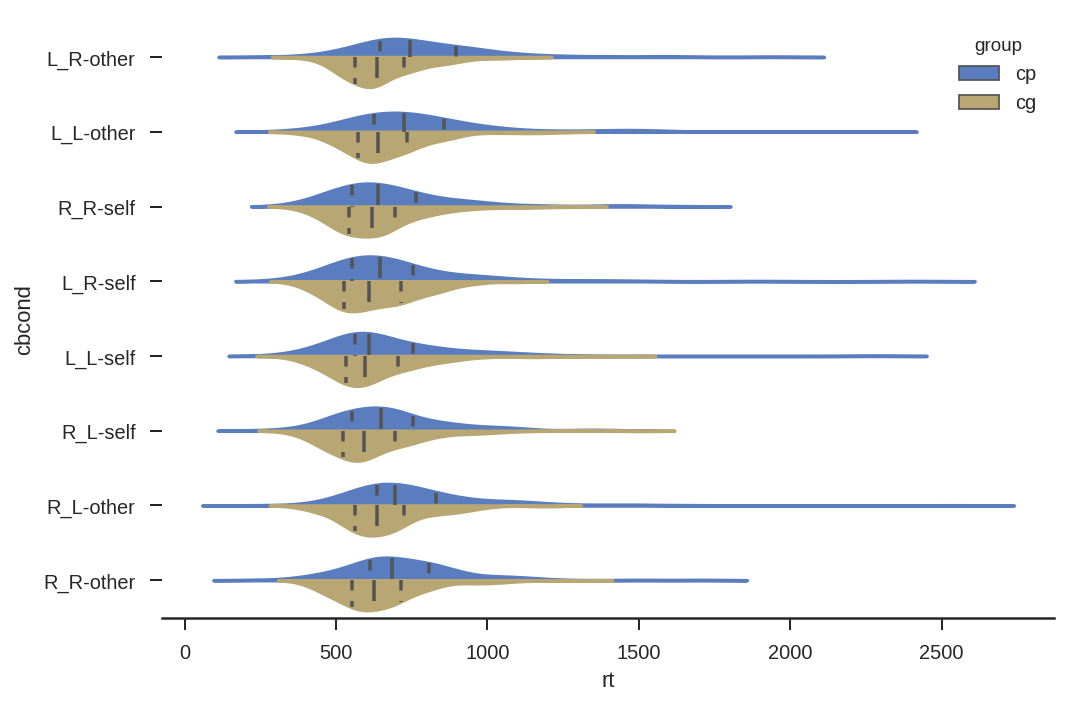

In [2]:
# load data
import pandas as pd
Tbl_beh  = pd.read_csv('./behavioral_data.txt', delimiter='\t')
Tbl_beh["subj"]  = Tbl_beh["subj"].astype('category')
#%% visualized data
# Draw a nested violinplot and split the violins for easier comparison
sns.set(style="ticks", palette="muted", color_codes=True)
plt.figure()
Tbl_beh['cbcond']  = pd.Series(Tbl_beh['chimera'] + '-' + Tbl_beh['identity'], index=Tbl_beh.index)
sns.violinplot(y="cbcond", x="rt", hue="group", data=Tbl_beh, split=True,
               inner="quart", palette={"cp": "b", "cg": "y"})
sns.despine(left=True)

`Tbl_beh` is the raw data table.  

In [3]:
Tbl_beh.head(5)

,subj,trial,chimera,identity,orientation,rt,acc,group,cbcond
0,1,1,L_R,other,upright,754.6,0,cp,L_R-other
1,1,2,L_L,other,upright,1036.1,1,cp,L_L-other
2,1,3,R_R,self,upright,433.0,1,cp,R_R-self
3,1,4,L_R,self,upright,463.4,1,cp,L_R-self
4,1,5,L_L,self,upright,483.3,1,cp,L_L-self


In [4]:
#%% Compute the conditional mean of dataset
condi_sel = ['subj', 'chimera', 'identity', 'orientation']
tblmean = pd.DataFrame({'Nt' : Tbl_beh.groupby( condi_sel ).size()}).reset_index()
tblmean["subj"] = tblmean["subj"].astype('category')
tblmean['rt']  = np.asarray(Tbl_beh.groupby(condi_sel)['rt'].mean())
tblmean['ACC'] = np.asarray(Tbl_beh.groupby(condi_sel)['acc'].mean())
tblmean['group']= np.asarray(Tbl_beh.groupby(condi_sel)['group'].all())

`tblmean` is the summary data table.  

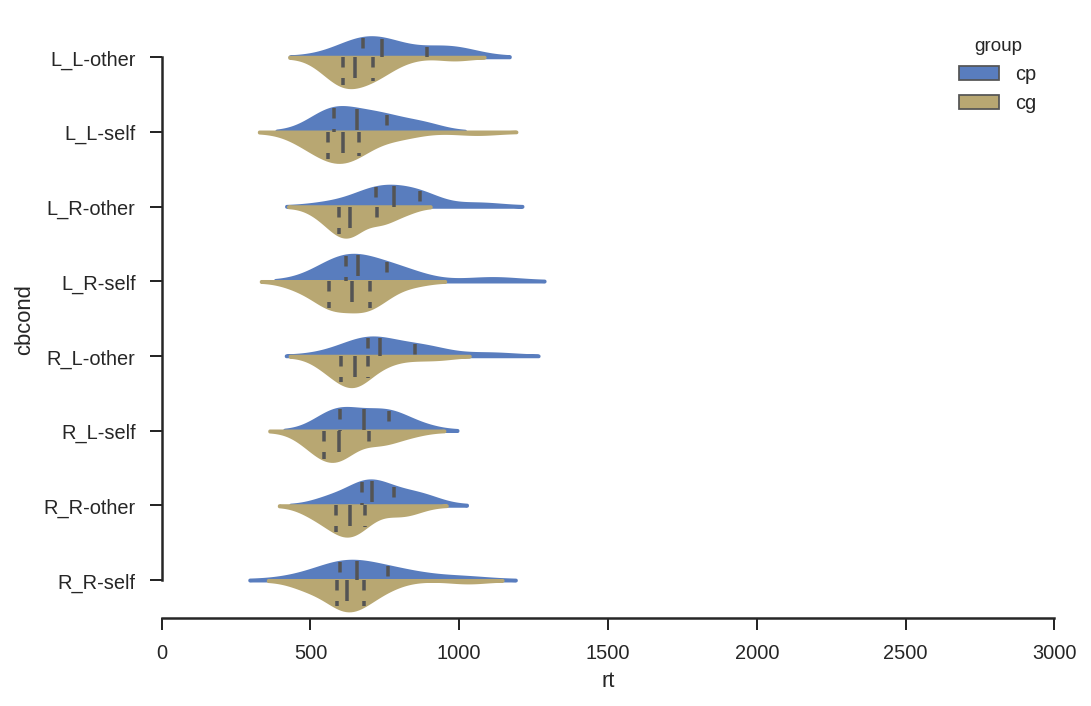

In [5]:
tblmean['cbcond']  = pd.Series(tblmean['chimera'] + '-' + tblmean['identity'], 
                index=tblmean.index)

## boxplot + scatter plot to show accuracy
#ax = sns.boxplot(y="cbcond", x="acc", data=tbltest,
#                 whis=np.inf, color="c")
## Add in points to show each observation
#sns.stripplot(y="cbcond", x="acc", data=tbltest,
#              jitter=True, size=3, color=".3", linewidth=0)
plt.figure()
g1 = sns.violinplot(y="cbcond", x="rt", hue="group", data=tblmean, split=True,
               inner="quart", palette={"cp": "b", "cg": "y"})
g1.set(xlim=(0, 3000))
# Make the quantitative axis logarithmic
sns.despine(trim=True)

In [6]:
tblmean.head(5)

,subj,chimera,identity,orientation,Nt,rt,ACC,group,cbcond
0,1,L_L,other,inverted,10,713.37,0.8,cp,L_L-other
1,1,L_L,other,upright,10,749.55,0.8,cp,L_L-other
2,1,L_L,self,inverted,10,538.64,0.6,cp,L_L-self
3,1,L_L,self,upright,10,629.01,0.9,cp,L_L-self
4,1,L_R,other,inverted,10,784.70,1.0,cp,L_R-other


Here I used the mean table as the data - it is smaller and faster to run

In [7]:
tbltest = tblmean
tbltest.shape

(320, 9)

# Using StatsModels to perform a linear mixed model of reaction time

In [8]:
import statsmodels.formula.api as smf
from patsy import dmatrices
formula = "rt ~ group*orientation*identity"
#formula = "rt ~ -1 + cbcond"
md  = smf.mixedlm(formula, tbltest, groups=tbltest["subj"])
mdf = md.fit()
print(mdf.summary())

fe_params = pd.DataFrame(mdf.fe_params,columns=['LMM'])
random_effects = pd.DataFrame(mdf.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

#%% Generate Design Matrix for later use
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               rt        
No. Observations:                320                   Method:                           REML      
No. Groups:                      20                    Scale:                            4502.8886 
Min. group size:                 16                    Likelihood:                       -1796.2120
Max. group size:                 16                    Converged:                        Yes       
Mean group size:                 16.0                                                              
---------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

A helper function for ploting

The MSE of LMM is 4150.21209997


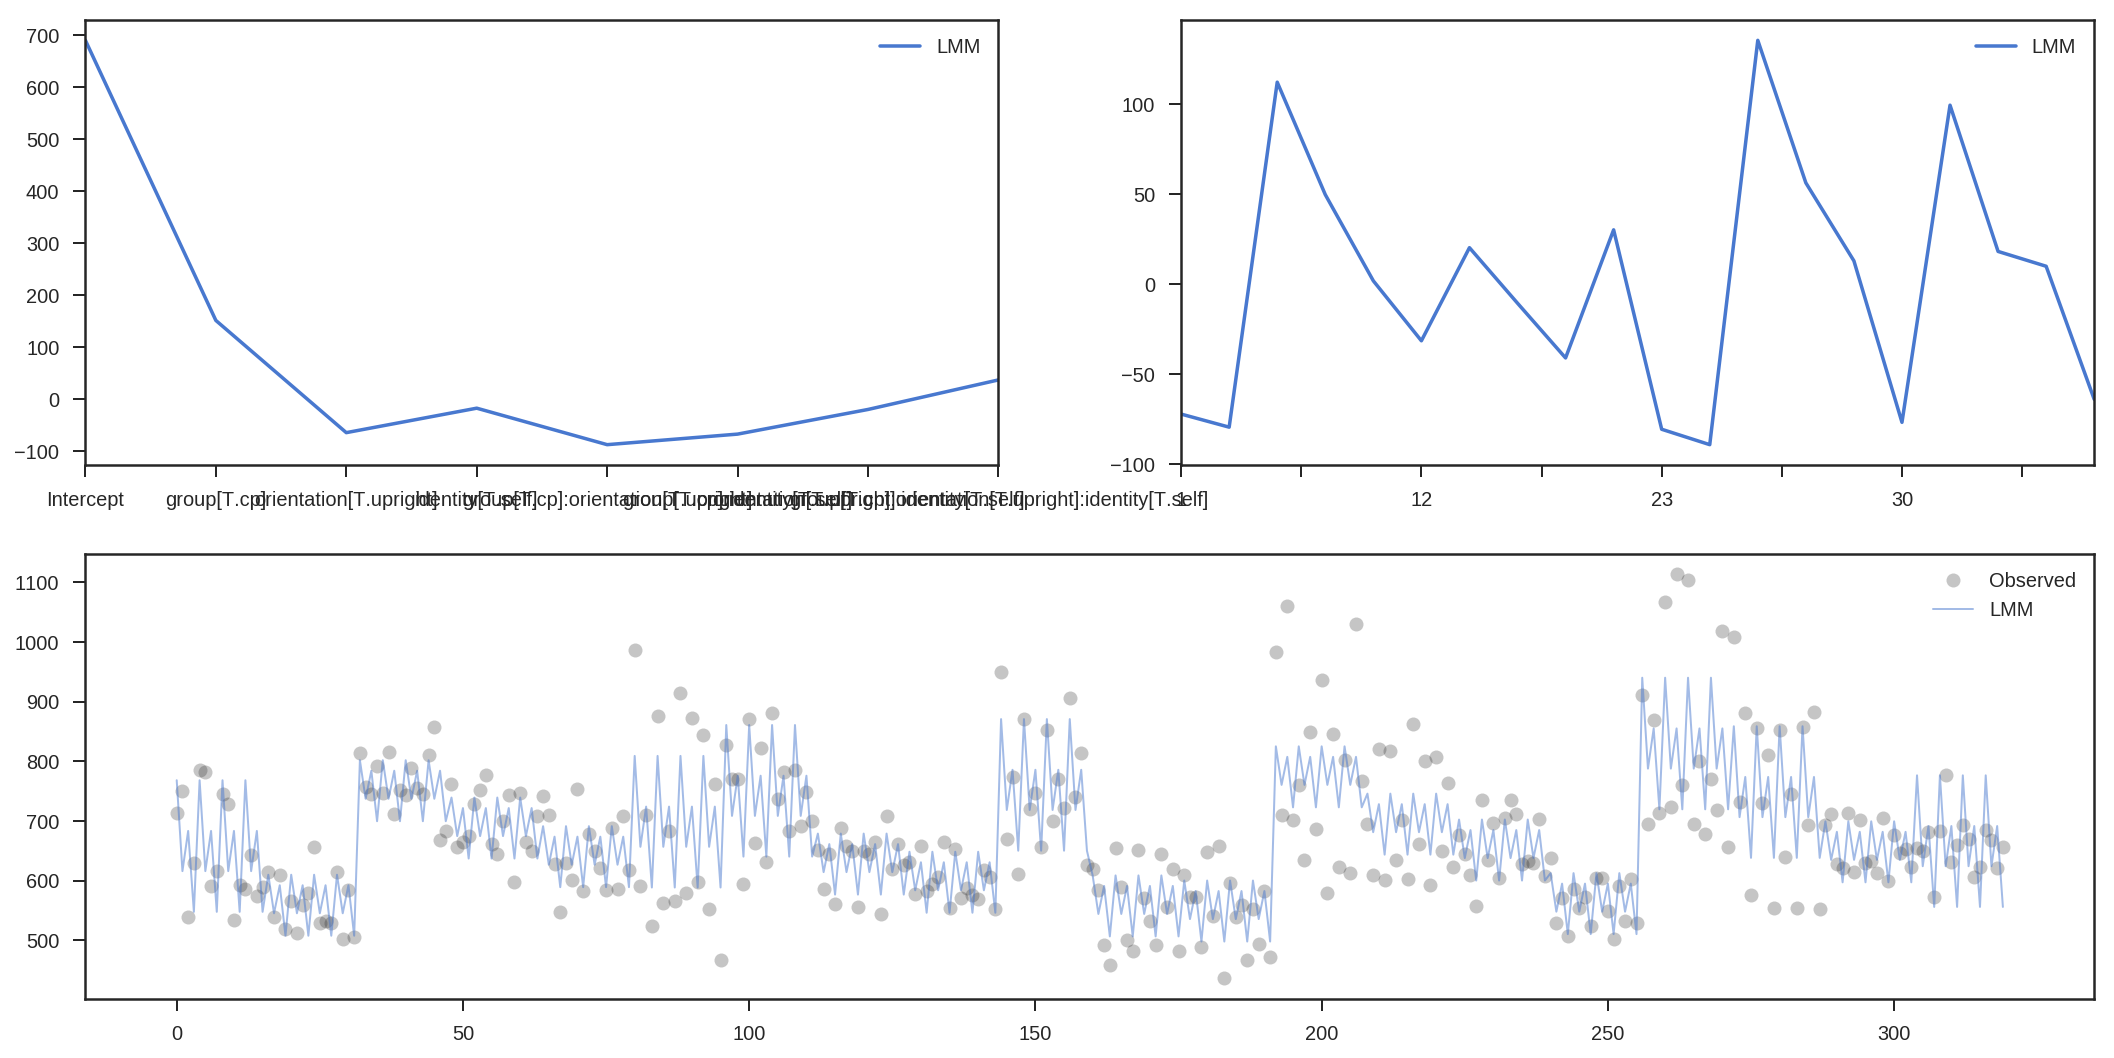

In [9]:
#%% ploting function 
def plotfitted(fe_params=fe_params,random_effects=random_effects,X=X,Z=Z,Y=Y):
    plt.figure(figsize=(18,9))
    ax1 = plt.subplot2grid((2,2), (0, 0))
    ax2 = plt.subplot2grid((2,2), (0, 1))
    ax3 = plt.subplot2grid((2,2), (1, 0), colspan=2)
    
    fe_params.plot(ax=ax1)
    random_effects.plot(ax=ax2)
    
    ax3.plot(Y.flatten(),'o',color='k',label = 'Observed', alpha=.25)
    for iname in fe_params.columns.get_values():
        fitted = np.dot(X,fe_params[iname])+np.dot(Z,random_effects[iname]).flatten()
        print("The MSE of "+iname+ " is " + str(np.mean(np.square(Y.flatten()-fitted))))
        ax3.plot(fitted,lw=1,label = iname, alpha=.5)
    ax3.legend(loc=0)
    #plt.ylim([0,5])
    plt.show()

plotfitted(fe_params=fe_params,random_effects=random_effects,X=X,Z=Z,Y=Y)

# Using PyMC3

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1.5199e+06:  15%|█▍        | 29872/200000 [00:02<00:15, 11341.67it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -4,289.6

100%|██████████| 3000/3000 [00:22<00:00, 134.71it/s]


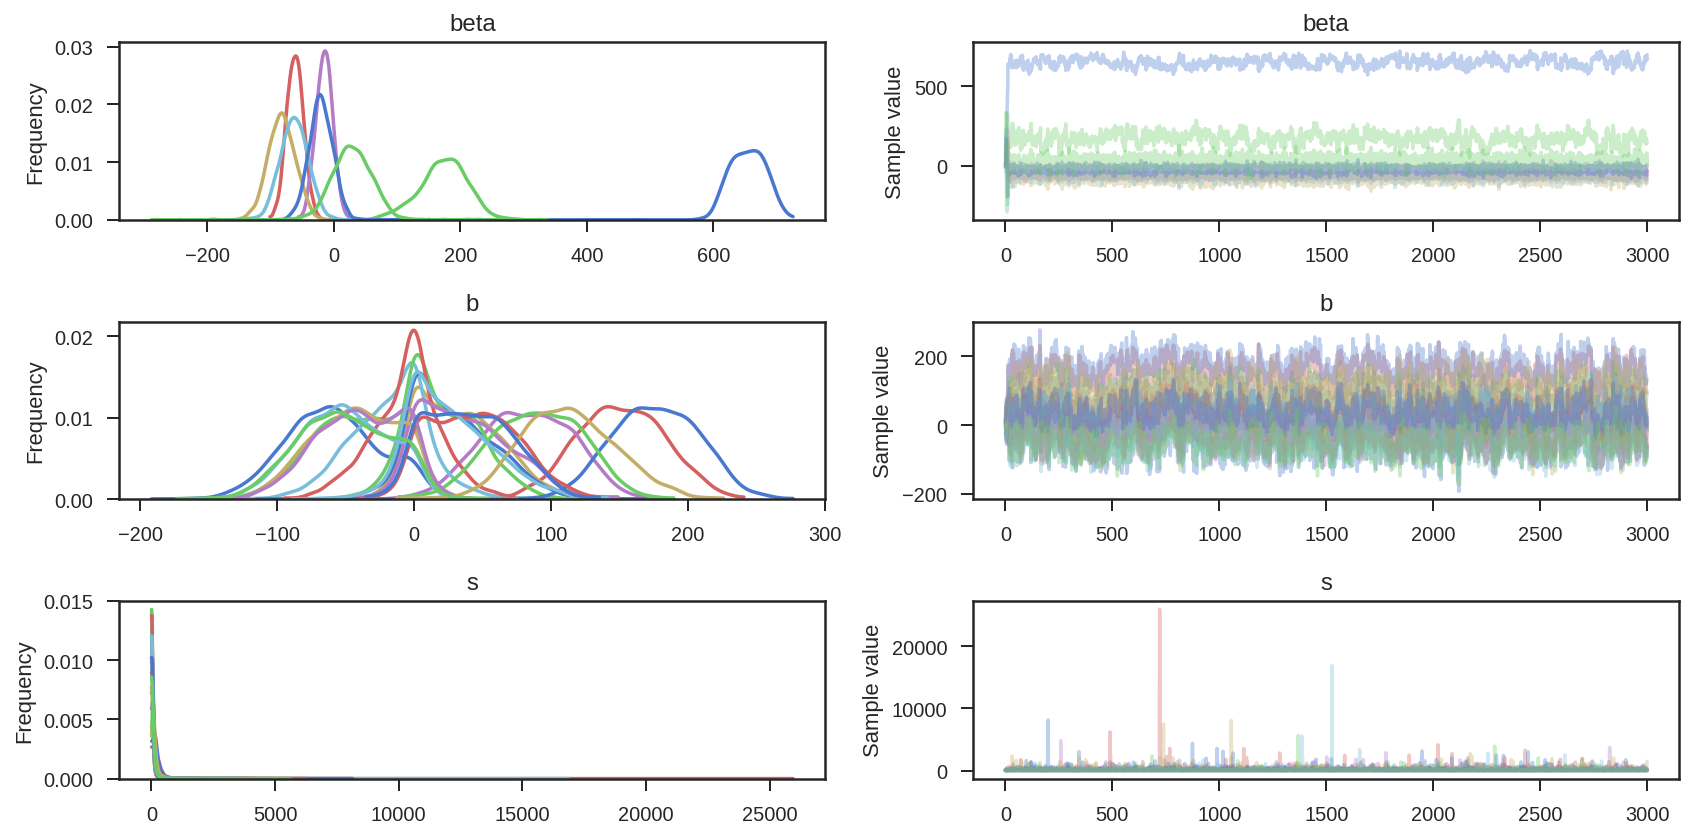

                                                           LMM        PyMC
Intercept                                           689.537735  654.384595
group[T.cp]                                         151.112622  167.242870
orientation[T.upright]                              -64.601774  -61.303425
identity[T.self]                                    -17.581122  -15.093120
group[T.cp]:orientation[T.upright]                  -87.712115  -83.895942
group[T.cp]:identity[T.self]                        -67.411021  -63.262019
orientation[T.upright]:identity[T.self]             -20.020417  -21.830602
group[T.cp]:orientation[T.upright]:identity[T.s...   36.768234   29.092139


In [10]:
beta0     = np.linalg.lstsq(X,Y)

fixedpred = np.argmax(X,axis=1)
randmpred = np.argmax(Z,axis=1)

con  = tt.constant(fixedpred)
sbj  = tt.constant(randmpred)
import pymc3 as pm
with pm.Model() as glmm1:
    # Fixed effect
    beta = pm.Normal('beta', mu = 0, sd = 100, shape=(nfixed[1]))
    # random effect
    s    = pm.HalfCauchy('s',50,shape=(nrandm[1]))
    b    = pm.Normal('b', mu = 0, sd = s, shape=(nrandm[1]))
    eps  = pm.HalfCauchy('eps', 5)
    
    #mu_est = pm.Deterministic('mu_est',beta[con] + b[sbj])
    mu_est = pm.Deterministic('mu_est',tt.dot(X,beta)+tt.dot(Z,b))
    RT = pm.Normal('RT', mu_est, eps, observed = Y)
    
    # start = pm.find_MAP()
    # h = find_hessian(start)

with glmm1:
    # means, sds, elbos = pm.variational.advi(n=100000)
    trace = pm.sample(3000)
    
pm.traceplot(trace,varnames=['beta','b','s']) # 
plt.show()

burnin1 = 2000
fixed_pymc = pm.df_summary(trace[burnin1:],varnames=['beta'])
randm_pymc = pm.df_summary(trace[burnin1:],varnames=['b'])
fe_params['PyMC'] = pd.Series(np.asarray(fixed_pymc['mean']), index=fe_params.index)
random_effects['PyMC'] = pd.Series(np.asarray(randm_pymc['mean']),index=random_effects.index)
print(fe_params)

# Using Theano
This is a non-probabilistic model, but none-the-less uncertainty related to parameter estimation could be obtained using dropout (http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html).

In [11]:
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

X = X.astype(np.float32)
Z = Z.astype(np.float32)
Y = Y.astype(np.float32)

import theano
theano.config.compute_test_value = 'ignore'

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def model(X, beta, Z, b):
    return tt.sum(tt.dot(X, beta) + tt.dot(Z, b),axis=1)

def sgd(cost, params, lr=0.001):
    grads = tt.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates
    
Xtf   = tt.fmatrix()
Ztf   = tt.fmatrix()
y     = tt.vector()
tbeta = init_weights([nfixed[1], 1])
tb    = init_weights([nrandm[1], 1])
eps   = init_weights([0])
y_    = model(Xtf, tbeta, Ztf,tb)

cost    = tt.mean(tt.sqr(y - y_))
params  = [tbeta, tb]
updates = sgd(cost, params)

train = theano.function(inputs=[Xtf, Ztf, y], outputs=cost, updates=updates, allow_input_downcast=True)

for i in range(100000):
    sel = np.random.randint(0,nfixed[0],size=int(nfixed[0]/2))
    batch_xs, batch_zs, batch_ys = X[sel,:],Z[sel,:],Y[sel]
    train(batch_xs, batch_zs, batch_ys)
        
outdf = pd.DataFrame(data=tbeta.get_value(),columns=['beta'],index=Terms)
fe_params['theano'] = pd.Series(tbeta.get_value().flatten(), index=fe_params.index)
random_effects['theano'] = pd.Series(tb.get_value().flatten() ,index=random_effects.index)
print(fe_params)

                                                           LMM        PyMC  \
Intercept                                           689.537735  654.384595   
group[T.cp]                                         151.112622  167.242870   
orientation[T.upright]                              -64.601774  -61.303425   
identity[T.self]                                    -17.581122  -15.093120   
group[T.cp]:orientation[T.upright]                  -87.712115  -83.895942   
group[T.cp]:identity[T.self]                        -67.411021  -63.262019   
orientation[T.upright]:identity[T.self]             -20.020417  -21.830602   
group[T.cp]:orientation[T.upright]:identity[T.s...   36.768234   29.092139   

                                                        theano  
Intercept                                           653.075051  
group[T.cp]                                         162.625950  
orientation[T.upright]                              -66.552995  
identity[T.self]                     

# Using TensorFlow

In [12]:
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y)
nfixed = np.shape(X)
nrandm = np.shape(Z)

X = X.astype(np.float32)
Z = Z.astype(np.float32)
Y = Y.astype(np.float32)

import tensorflow as tf
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, beta, Z, b):
    y_pred = tf.matmul(X, beta) + tf.matmul(Z, b)
    #randcoef = tf.matmul(Z, b)
    #Xnew     = tf.transpose(X) * tf.transpose(randcoef)
    #y_pred   = tf.matmul(tf.transpose(Xnew), beta)
    return y_pred # notice we use the same model as linear regression, 
                  # this is because there is a baked in cost function which performs softmax and cross entropy

Xtf   = tf.placeholder("float32", [None, nfixed[1]]) # create symbolic variables
Ztf   = tf.placeholder("float32", [None, nrandm[1]])
y     = tf.placeholder("float32", [None, 1])
beta  = init_weights([nfixed[1], 1])
b     = init_weights([nrandm[1], 1])
eps   = init_weights([0])
y_    = model(Xtf, beta, Ztf, b)
# y_    = tf.nn.softmax(model(Xtf, beta) + model(Ztf, b) + eps)

# cost  = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_), reduction_indices=[1]))
cost  = tf.square(y - y_) # use square error for cost function

train_step    = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

init          = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver         = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for i in range(2000):
        sel = np.random.randint(0,nfixed[0],size=int(nfixed[0]/2))
        batch_xs, batch_zs, batch_ys = X[sel,:],Z[sel,:],Y[sel]
        sess.run(train_step, feed_dict={Xtf: batch_xs, Ztf: batch_zs, y: batch_ys})
        
        accuracy = tf.reduce_mean(tf.cast(cost, tf.float32))
        if i % 1000 == 0:        
            print(i,sess.run(accuracy, feed_dict={Xtf: X, Ztf: Z, y: Y}))

    betaend = sess.run(beta)
    bend    = sess.run(b)
    
fe_params['tf'] = pd.Series(betaend.flatten(), index=fe_params.index)
random_effects['tf'] = pd.Series(bend.flatten(), index=random_effects.index)
print(fe_params)

0 413715.0
1000 4528.67
                                                           LMM        PyMC  \
Intercept                                           689.537735  654.384595   
group[T.cp]                                         151.112622  167.242870   
orientation[T.upright]                              -64.601774  -61.303425   
identity[T.self]                                    -17.581122  -15.093120   
group[T.cp]:orientation[T.upright]                  -87.712115  -83.895942   
group[T.cp]:identity[T.self]                        -67.411021  -63.262019   
orientation[T.upright]:identity[T.self]             -20.020417  -21.830602   
group[T.cp]:orientation[T.upright]:identity[T.s...   36.768234   29.092139   

                                                        theano          tf  
Intercept                                           653.075051  650.617249  
group[T.cp]                                         162.625950  158.134583  
orientation[T.upright]                    

# PyMC3 again 
model similar to brms

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,980.8:  42%|████▏     | 83154/200000 [00:06<00:09, 11921.39it/s]   Median ELBO converged.
Finished [100%]: Average ELBO = -1,973.9

100%|██████████| 3000/3000 [00:16<00:00, 176.86it/s]


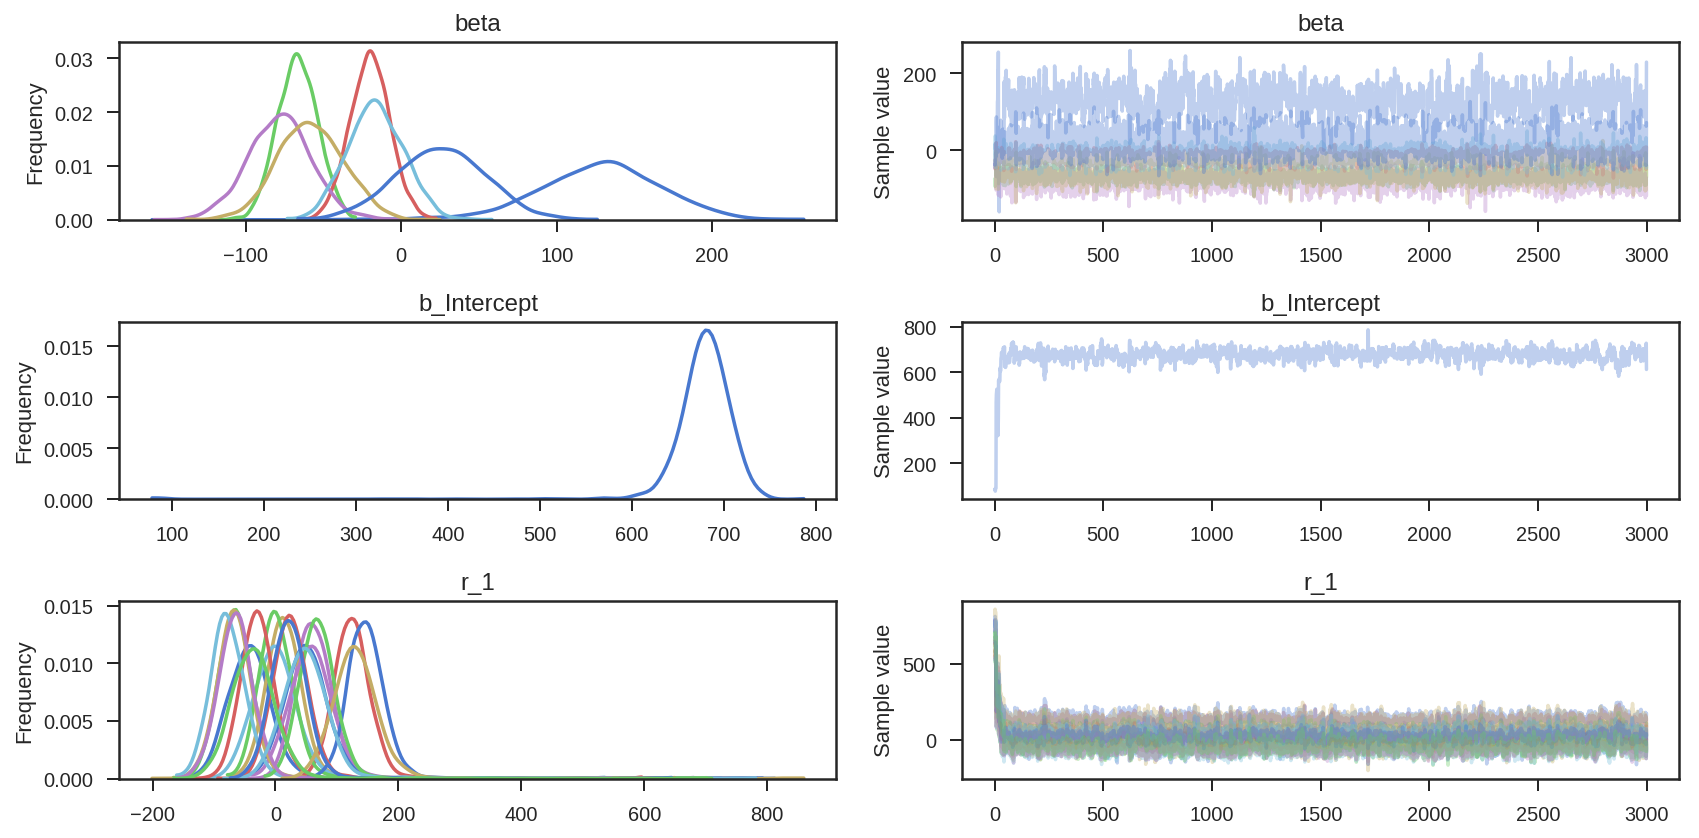

In [13]:
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)
beta0     = np.linalg.lstsq(X,Y)

fixedpred = np.argmax(X,axis=1)
randmpred = np.argmax(Z,axis=1)

con  = tt.constant(fixedpred)
sbj  = tt.constant(randmpred)
import pymc3 as pm

X1     = X[0:,1:]
X_mean = np.mean(X1,axis=0) # column means of X before centering 
X_cent = X1 - X_mean

with pm.Model() as glmm2:
    # Fixed effect
    beta = pm.Normal('beta', mu = 0, sd = 100, shape=(nfixed[1]-1))
    
    # temporary Intercept 
    #temp_Intercept = pm.Flat('temp_Intercept')
    temp_Intercept = pm.Normal('temp_Intercept', mu = 0, sd = 100)
                               
    # random effect
    # group-specific standard deviation
    s      = pm.HalfCauchy('s', 5)#pm.StudentT('s',nu=3, mu=0, sd=186)#
    b      = pm.Normal('b', mu = 0, sd = 1, shape=(nrandm[1]))
    r_1    = pm.Deterministic('r_1',s*b)
    sigma  = pm.HalfCauchy('sigma', 5)#pm.StudentT('eps',nu=3, mu=0, sd=186)#
    
    # compute linear predictor 
    mu_est = tt.dot(X_cent,beta) + temp_Intercept + r_1[sbj]
    
    RT = pm.Normal('RT', mu_est, sigma, observed = Y)
    b_Intercept = pm.Deterministic("b_Intercept", temp_Intercept - tt.sum(X_mean * beta))
    # start = pm.find_MAP()
    # h = find_hessian(start)
    
with glmm2:
    # means, sds, elbos = pm.variational.advi(n=100000)
    trace2 = pm.sample(3000)

pm.traceplot(trace2,varnames=['beta','b_Intercept','r_1']) # 
plt.show()

In [14]:
burnin2    = 2000
df_summary = pm.df_summary(trace2[burnin2:],varnames=['beta'])
df_stmp    = pm.df_summary(trace2[burnin2:],varnames=['b_Intercept']) #['temp_Intercept']
df_new     = df_stmp.append(df_summary, ignore_index=True)
df_new.index=Terms

randm_pymc = pm.df_summary(trace2[burnin2:],varnames=['r_1'])
fe_params['PyMC2'] = pd.Series(np.asarray(df_new['mean']), index=fe_params.index)
random_effects['PyMC2'] = pd.Series(np.asarray(randm_pymc['mean']),index=random_effects.index)
print(fe_params)

                                                           LMM        PyMC  \
Intercept                                           689.537735  654.384595   
group[T.cp]                                         151.112622  167.242870   
orientation[T.upright]                              -64.601774  -61.303425   
identity[T.self]                                    -17.581122  -15.093120   
group[T.cp]:orientation[T.upright]                  -87.712115  -83.895942   
group[T.cp]:identity[T.self]                        -67.411021  -63.262019   
orientation[T.upright]:identity[T.self]             -20.020417  -21.830602   
group[T.cp]:orientation[T.upright]:identity[T.s...   36.768234   29.092139   

                                                        theano          tf  \
Intercept                                           653.075051  650.617249   
group[T.cp]                                         162.625950  158.134583   
orientation[T.upright]                              -66.552995 

# Usint PyStan (Model is constructed using brm in R)  


```r
library(lme4)
library(brms)
```
```
Tbl_beh <- read.csv("behavioral_data.txt",sep = "\t")
Tbl_beh$subj <- factor(Tbl_beh$subj)
Tbl_beh$trial <- factor(Tbl_beh$trial)
stanmodel <- make_stancode(rt ~ group*orientation*identity + (1|subj),
                data = Tbl_beh,family = "normal")
standata  <- make_standata(rt ~ group*orientation*identity + (1|subj),
                          data = Tbl_beh,family = "normal")
bayesfit <- brm(rt ~ group*orientation*identity + (1|subj),
                data = Tbl_beh,family = "normal")
bayesfit$model
summary(bayesfit, waic = TRUE)
```
```
lmefit <- lmer(rt ~ group*orientation*identity + (1|subj),
                 data = Tbl_beh)
summary(lmefit)
```

In [15]:
stan_datadict = {}
stan_datadict['N'] = Y.shape[0]
stan_datadict['Y'] = Y
stan_datadict['K'] = X1.shape[1]
stan_datadict['X'] = X_cent
stan_datadict['X_means'] = X_mean

stan_datadict['J_1'] = randmpred + 1
stan_datadict['N_1'] = max(randmpred + 1)
stan_datadict['K_1'] = 1
stan_datadict['Z_1'] = np.ones(randmpred.shape)

stan_datadict['prior_only'] = 0
#stan_datadict.items()

In [16]:
stan_mdlspec_lmm = """
    // This Stan code was generated with the R package 'brms'. 
    // We recommend generating the data with the 'make_standata' function. 
    functions { 
    } 
    data { 
      int<lower=1> N;  // total number of observations 
      vector[N] Y;  // response variable 
      int<lower=1> K;  // number of population-level effects 
      matrix[N, K] X;  // centered population-level design matrix 
      vector[K] X_means;  // column means of X before centering 
      // data for group-specific effects of subj 
      int<lower=1> J_1[N]; 
      int<lower=1> N_1; 
      int<lower=1> K_1; 
      vector[N] Z_1; 
      int prior_only;  // should the likelihood be ignored? 
    } 
    transformed data { 
    } 
    parameters { 
      vector[K] b;  // population-level effects 
      real temp_Intercept;  // temporary Intercept 
      real<lower=0> sd_1;  // group-specific standard deviation 
      vector[N_1] z_1;  // unscaled group-specific effects 
      real<lower=0> sigma;  // residual SD 
    } 
    transformed parameters { 
      // group-specific effects 
      vector[N_1] r_1; 
      vector[N] eta;  // linear predictor 
      r_1 <- sd_1 * (z_1);
      // compute linear predictor 
      eta <- X * b + temp_Intercept; 
      for (n in 1:N) { 
        eta[n] <- eta[n] + r_1[J_1[n]] * Z_1[n]; 
      } 
    } 
    model { 
      // prior specifications 
      sd_1 ~ student_t(3, 0, 186); 
      z_1 ~ normal(0, 1); 
      sigma ~ student_t(3, 0, 186); 
      // likelihood contribution 
      if (!prior_only) { 
        Y ~ normal(eta, sigma); 
      } 
    } 
    generated quantities { 
      real b_Intercept;  // population-level intercept 
      b_Intercept <- temp_Intercept - dot_product(X_means, b); 
    } 
    """

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f1c55ea88fca682f1405da3e975196f NOW.


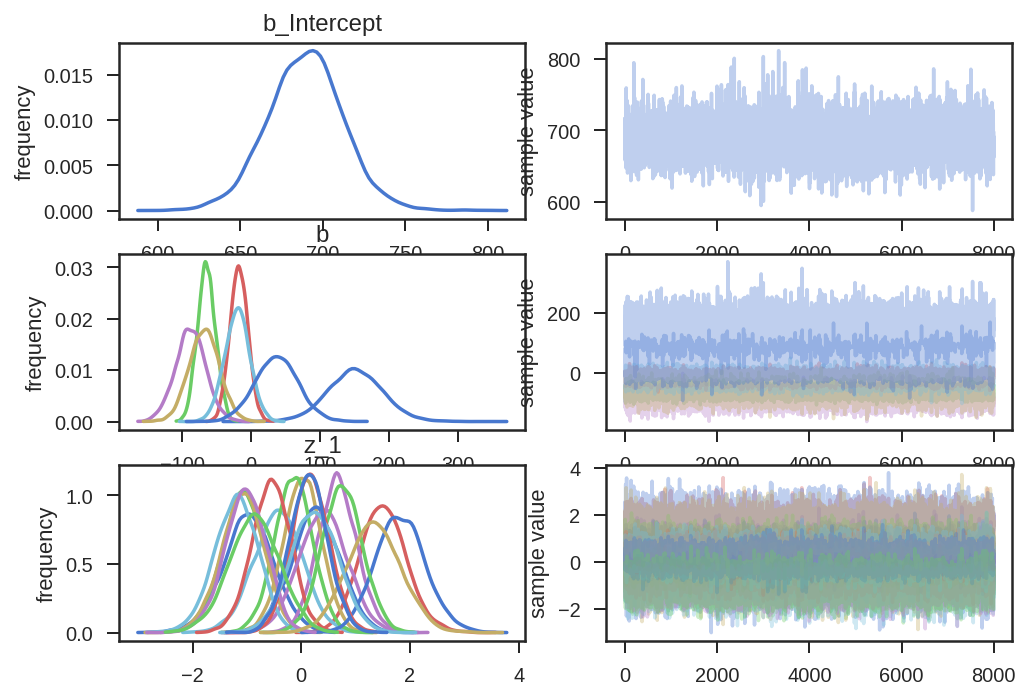

In [17]:
import pystan
stan_fit_lmm = pystan.stan(model_code=stan_mdlspec_lmm, data=stan_datadict,
                           iter=3000, warmup=1000, chains=4, n_jobs=2,verbose=False)
stan_fit_lmm.plot(pars=['b_Intercept','b','z_1'])
plt.show()

In [18]:
Itercept = stan_fit_lmm.extract(permuted=True)['b_Intercept']
betatemp = stan_fit_lmm.extract(permuted=True)['b']
btemp    = stan_fit_lmm.extract(permuted=True)['z_1']
sdtemp   = stan_fit_lmm.extract(permuted=True)['sd_1']
betastan = np.hstack([Itercept.mean(axis=0),betatemp.mean(axis=0)])
bstan    = btemp.mean(axis=0)*sdtemp.mean(axis=0)

fe_params['Stan'] = pd.Series(betastan, index=fe_params.index)
random_effects['Stan'] = pd.Series(bstan,index=random_effects.index)
print(fe_params)

                                                           LMM        PyMC  \
Intercept                                           689.537735  654.384595   
group[T.cp]                                         151.112622  167.242870   
orientation[T.upright]                              -64.601774  -61.303425   
identity[T.self]                                    -17.581122  -15.093120   
group[T.cp]:orientation[T.upright]                  -87.712115  -83.895942   
group[T.cp]:identity[T.self]                        -67.411021  -63.262019   
orientation[T.upright]:identity[T.self]             -20.020417  -21.830602   
group[T.cp]:orientation[T.upright]:identity[T.s...   36.768234   29.092139   

                                                        theano          tf  \
Intercept                                           653.075051  650.617249   
group[T.cp]                                         162.625950  158.134583   
orientation[T.upright]                              -66.552995 

# Using Keras

In [37]:
from keras.models import Sequential
from keras.layers import merge
from keras.layers.core import Dense

fixed_keras = Sequential()
fixed_keras.add(Dense(1, input_dim=X.shape[1]-1))

randm_keras = Sequential()
randm_keras.add(Dense(1, input_dim=Z.shape[1],use_bias=None))

merged = Merge([fixed_keras, randm_keras], mode='sum')

model = Sequential()
model.add(merged)

model.compile(loss='mean_squared_error', optimizer='sgd')

# train the model
model.fit([X[:,1:], Z], Y, epochs=1000, batch_size=100, verbose=0)

betakeras = np.hstack((model.get_weights()[0][1],model.get_weights()[0][0].flatten()))
bkeras = model.get_weights()[1][0]
fe_params['Keras'] = pd.Series(betakeras.flatten(), index=fe_params.index)
random_effects['Keras'] = pd.Series(bkeras.flatten(),index=random_effects.index)
print(fe_params)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.5/dist-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


                                                           LMM        PyMC  \
Intercept                                           689.537735  654.384595   
group[T.cp]                                         151.112622  167.242870   
orientation[T.upright]                              -64.601774  -61.303425   
identity[T.self]                                    -17.581122  -15.093120   
group[T.cp]:orientation[T.upright]                  -87.712115  -83.895942   
group[T.cp]:identity[T.self]                        -67.411021  -63.262019   
orientation[T.upright]:identity[T.self]             -20.020417  -21.830602   
group[T.cp]:orientation[T.upright]:identity[T.s...   36.768234   29.092139   

                                                        theano          tf  \
Intercept                                           653.075051  650.617249   
group[T.cp]                                         162.625950  158.134583   
orientation[T.upright]                              -66.552995 

# Display estimation

The MSE of LMM is 4150.21209997
The MSE of PyMC is 4171.14904091
The MSE of theano is 4138.09488601
The MSE of tf is 4165.54280855
The MSE of PyMC2 is 4153.69367087
The MSE of Stan is 4138.99348742
The MSE of Keras is 4148.28259908


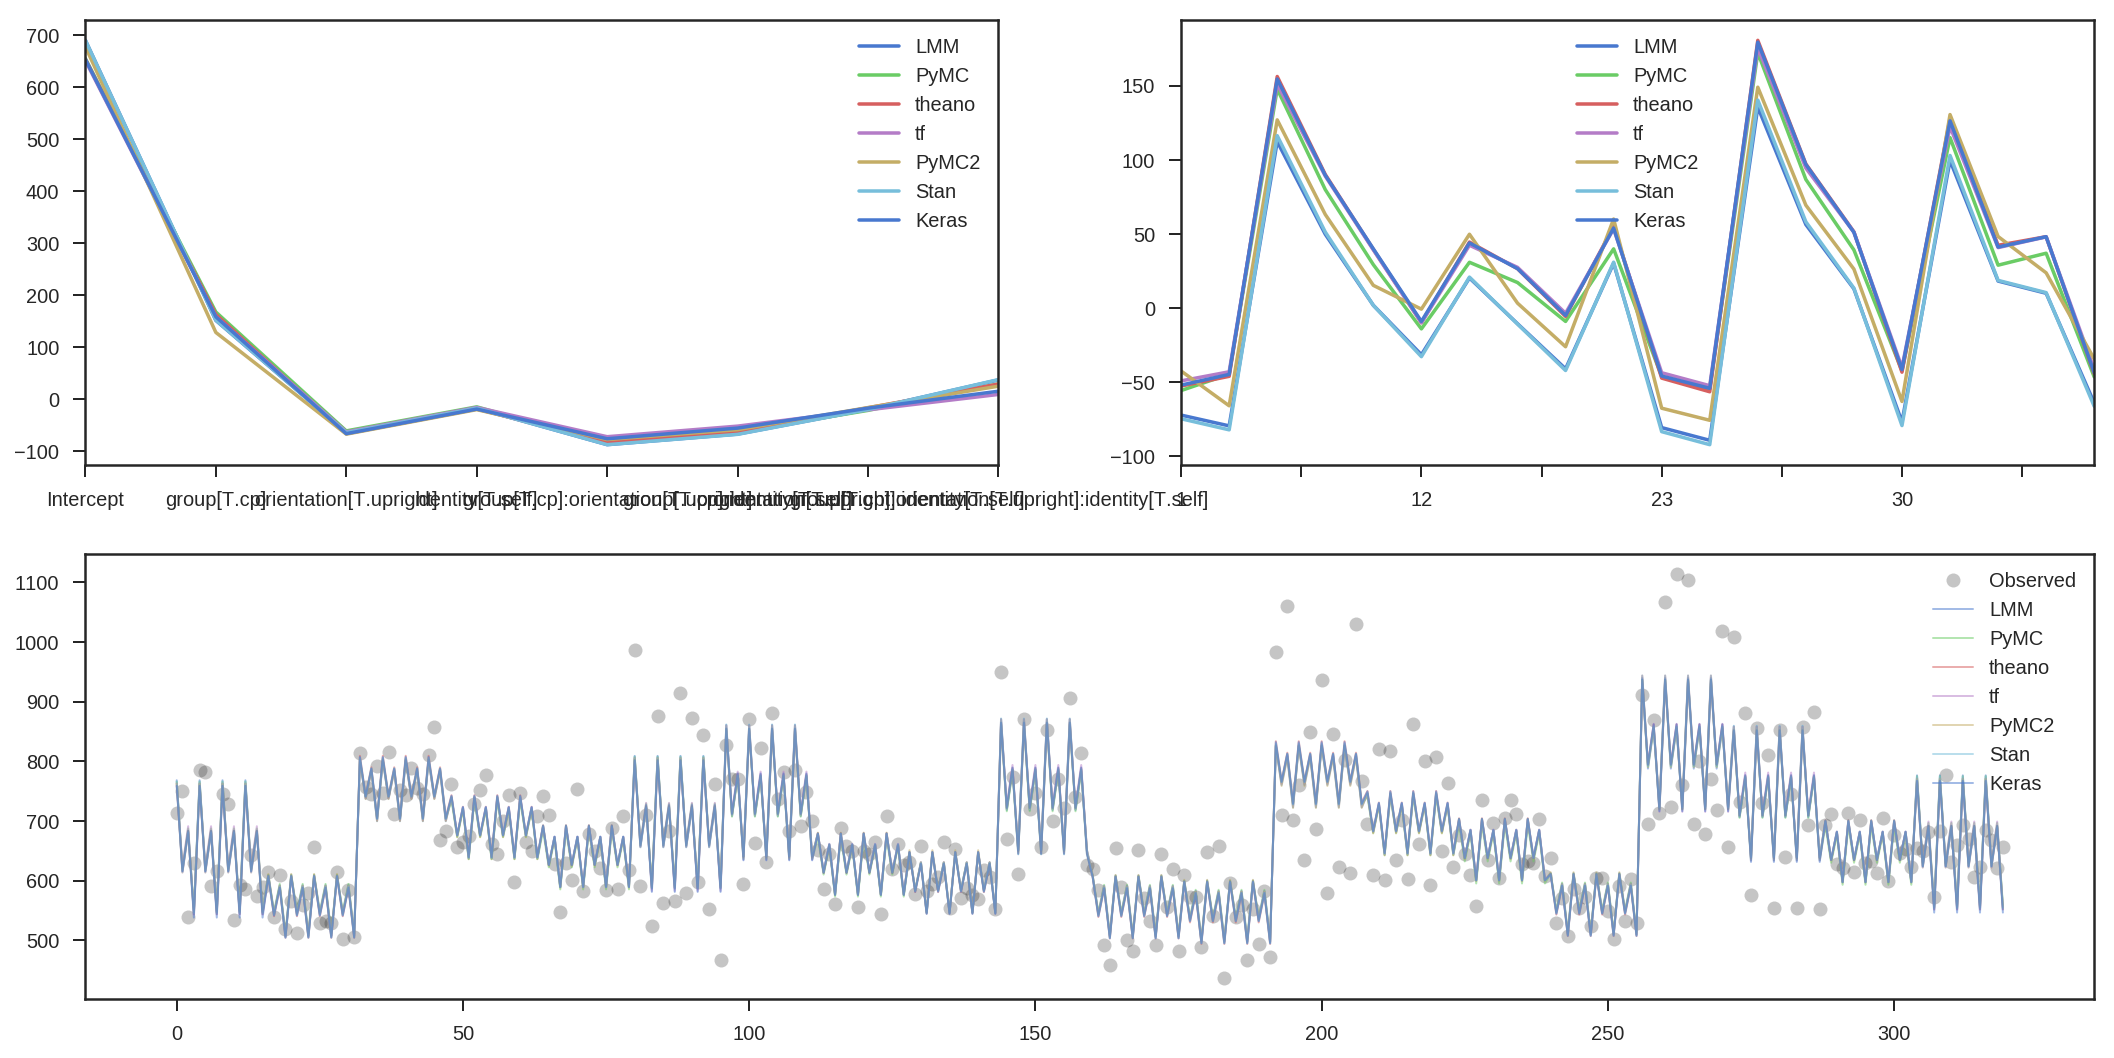

In [38]:
plotfitted(fe_params=fe_params,random_effects=random_effects,X=X,Z=Z,Y=Y)